# Start

In [15]:
# ==========================
# Assignment 3 (ENSO) 
# ==========================

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Paths ----------
DATA_DIR = Path("data/tos_Omon_MPI-ESM-P_past1000_r1i1p1_085001-184912")
OBS_PATH = DATA_DIR / "HadISST_sst.nc"
M1_PATH  = DATA_DIR / "mil0010_EH5_mm_SST.nc"

PAST_FILES = sorted(DATA_DIR.glob("tos_Omon_MPI-ESM-P_past1000_r1i1p1_*.nc"))
HIST_FILES = sorted(DATA_DIR.glob("tos_Omon_MPI-ESM-P_historical_r1i1p1_*.nc"))

print("OBS exists :", OBS_PATH.exists(), OBS_PATH)
print("M1 exists  :", M1_PATH.exists(), M1_PATH)
print("PAST files :", len(PAST_FILES))
print("HIST files :", len(HIST_FILES))

OBS exists : True data/tos_Omon_MPI-ESM-P_past1000_r1i1p1_085001-184912/HadISST_sst.nc
M1 exists  : True data/tos_Omon_MPI-ESM-P_past1000_r1i1p1_085001-184912/mil0010_EH5_mm_SST.nc
PAST files : 11
HIST files : 1


In [17]:
# ---------- Helpers ----------
def pick_sst(ds):
    for v in ["sst", "tos", "SST"]:
        if v in ds.data_vars:
            return ds[v]
    raise KeyError(f"No SST variable found. data_vars={list(ds.data_vars)}")

def to_0_360(da, lon_name):
    da = da.assign_coords({lon_name: (da[lon_name] % 360)})
    return da.sortby(lon_name) if da[lon_name].ndim == 1 else da

def sort_if_1d(da, coord_name):
    return da.sortby(coord_name) if (coord_name in da.coords and da[coord_name].ndim == 1) else da

def anoms_monthly(da):
    return da.groupby("time.month") - da.groupby("time.month").mean("time")

def area_weighted_mean(da, lat_name, lon_name):
    w = np.cos(np.deg2rad(da[lat_name]))
    return da.weighted(w).mean((lat_name, lon_name))

def nino34_index(sst_anom, lat_name, lon_name):
    # Niño3.4: 5S–5N, 170W–120W -> 190E–240E in 0–360
    box = sst_anom.sel(**{
        lat_name: slice(-5, 5),
        lon_name: slice(190, 240)
    })
    return area_weighted_mean(box, lat_name, lon_name)


In [18]:
# ---------- Load datasets ----------
obs = xr.open_dataset(OBS_PATH)
m1  = xr.open_dataset(M1_PATH)

# MPI-ESM-P: open past + hist with consistent CFTime, then concat
m2_past = xr.open_mfdataset(PAST_FILES, combine="by_coords", chunks={"time": 60}, decode_times=True, use_cftime=True)
m2_hist = xr.open_mfdataset(HIST_FILES, combine="by_coords", chunks={"time": 60}, decode_times=True, use_cftime=True)
m2 = xr.concat([m2_past, m2_hist], dim="time")


/workspaces/BERN03-Climate-system-modeling/venv/lib/python3.10/site-packages/xarray/coding/times.py:213: SerializationWarning: Ambiguous reference date string: 800-01-31 18:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0800-01-31 18:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  ref_date = _ensure_padded_year(ref_date)
/tmp/ipykernel_34041/2795181966.py:3: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  m1  = xr.open_dataset(M1_PATH)
/tmp/ipykernel_34041/2795181966.py:6: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Exampl

In [19]:
# ---------- Extract SST + standardize coords ----------
# OBS uses latitude/longitude
obs_sst = pick_sst(obs)
obs_sst = sort_if_1d(obs_sst, "latitude")
obs_sst = to_0_360(obs_sst, "longitude")

# M1 uses lat/lon
m1_sst = pick_sst(m1)
m1_sst = sort_if_1d(m1_sst, "lat")
m1_sst = to_0_360(m1_sst, "lon")

# M2 uses lat/lon
m2_sst = pick_sst(m2)
m2_sst = sort_if_1d(m2_sst, "lat")
m2_sst = to_0_360(m2_sst, "lon")


In [21]:
print(m2_past.lat.shape, m2_hist.lat.shape)
print(m2_past.lon.shape, m2_hist.lon.shape)


(220, 256) (220, 256)
(220, 256) (220, 256)


In [30]:
# --- robust open with cftime (no deprecation warning) ---
def open_ds_cftime(path, chunks=None):
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    return xr.open_dataset(path, decode_times=time_coder, chunks=chunks)

# --- helper: force 1D lat/lon and monotonic order ---
def normalize_latlon(da, lat_name="lat", lon_name="lon"):
    # lon to 0–360
    da = da.assign_coords({lon_name: (da[lon_name] % 360)})

    lat = da[lat_name]
    lon = da[lon_name]

    # ensure 1D coords
    if lat.ndim != 1 or lon.ndim != 1:
        raise ValueError("lat/lon must be 1D coordinates")

    # sort if decreasing
    if float(lat[0]) > float(lat[-1]):
        da = da.sortby(lat_name)
    if float(lon[0]) > float(lon[-1]):
        da = da.sortby(lon_name)

    return da

# --- ALWAYS SAFE subsetting using isel ---
def subset_by_isel_latlon_1d(da, lat_name, lon_name,
                             lat_min, lat_max, lon_min, lon_max):

    da = normalize_latlon(da, lat_name, lon_name)

    lat = da[lat_name].values
    lon = da[lon_name].values

    i0 = int(np.searchsorted(lat, lat_min, side="left"))
    i1 = int(np.searchsorted(lat, lat_max, side="right"))
    j0 = int(np.searchsorted(lon, lon_min, side="left"))
    j1 = int(np.searchsorted(lon, lon_max, side="right"))

    return da.isel(**{
        lat_name: slice(i0, i1),
        lon_name: slice(j0, j1)
    })

# ---------------------------
# NINO3.4 INDEX (this was missing)
# ---------------------------
def nino34_index(sst, lat_name="lat", lon_name="lon"):
    """
    Niño 3.4 SST index:
    area mean over 5S–5N, 170W–120W (190–240E)
    """
    sst = normalize_latlon(sst, lat_name, lon_name)

    box = subset_by_isel_latlon_1d(
        sst, lat_name, lon_name,
        -5, 5, 190, 240
    )

    # cosine-lat weighting
    weights = np.cos(np.deg2rad(box[lat_name]))
    weights = weights / weights.mean()

    return box.weighted(weights).mean(dim=(lat_name, lon_name))

# ---------------------------
# MONTHLY ANOMALIES (safe with cftime)
# ---------------------------
def monthly_anomalies(da):
    clim = da.groupby("time.month").mean("time")
    anom = da.groupby("time.month") - clim
    return anom, clim


# ---------------------------
# USAGE (example)
# ---------------------------
# obs_sst, m1_sst, m2_sst must be DataArray with dims (time, lat, lon)

# obs_sst = normalize_latlon(obs_sst, "latitude", "longitude")
# m1_sst  = normalize_latlon(m1_sst,  "lat", "lon")
# m2_sst  = normalize_latlon(m2_sst,  "lat", "lon")

# n34_obs = nino34_index(obs_sst, "latitude", "longitude")
# n34_m1  = nino34_index(m1_sst)
# n34_m2  = nino34_index(m2_sst)

# n34_obs_anom, n34_obs_clim = monthly_anomalies(n34_obs)

In [38]:
import numpy as np

print("m2_sst dims:", m2_sst.dims)
print("m2_sst coords:", list(m2_sst.coords))

for name in ["lat", "lon", "latitude", "longitude", "nav_lat", "nav_lon"]:
    if name in m2_sst.coords:
        v = m2_sst[name].values
        print("\nCOORD:", name)
        print("  shape:", m2_sst[name].shape, "ndim:", m2_sst[name].ndim, "dtype:", m2_sst[name].dtype)
        print("  attrs:", dict(m2_sst[name].attrs))
        print("  min/max:", np.nanmin(v), np.nanmax(v))


m2_sst dims: ('time', 'j', 'i')
m2_sst coords: ['time', 'j', 'i', 'lat', 'lon']

COORD: lat
  shape: (220, 256) ndim: 2 dtype: float32
  attrs: {'standard_name': 'latitude', 'long_name': 'latitude coordinate', 'units': 'degrees_north', 'bounds': 'lat_vertices'}
  min/max: -83.96551 89.7266

COORD: lon
  shape: (220, 256) ndim: 2 dtype: float32
  attrs: {}
  min/max: 0.007175368 359.99603


In [39]:
print("\nGLOBAL ATTRS (m2):")
for k in sorted(m2.attrs.keys()):
    print(k, ":", m2.attrs[k])



GLOBAL ATTRS (m2):
Conventions : CF-1.4
branch_time : 0.0
cmor_version : 2.6.0
comment : started from past1000 200 years spinup run.
contact : cmip5-mpi-esm@dkrz.de
creation_date : 2011-11-11T23:53:00Z
experiment : last millennium
experiment_id : past1000
forcing : GHG, Sl, Vl, LU
frequency : mon
history : Model raw output postprocessing with modelling environment (IMDI) at DKRZ: URL: http://svn-mad.zmaw.de/svn/mad/Model/IMDI/trunk, REV: 3949 2011-11-11T23:52:57Z CMOR rewrote data to comply with CF standards and CMIP5 requirements.
initialization_method : 1
institute_id : MPI-M
institution : Max Planck Institute for Meteorology
model_id : MPI-ESM-P
modeling_realm : ocean
parent_experiment : N/A
parent_experiment_id : N/A
parent_experiment_rip : N/A
physics_version : 1
product : output
project_id : CMIP5
realization : 1
references : ECHAM6: n/a; JSBACH: Raddatz et al., 2007. Will the tropical land biosphere dominate the climate-carbon cycle feedback during the twenty first century? Cli

In [40]:
import numpy as np

# 1) subset tropical Pacific using 2D mask (j,i grid)
def subset_m2_2d_latlon(da, lat2d, lon2d, lat_min, lat_max, lon_min, lon_max):
    lon360 = lon2d % 360
    mask = (lat2d >= lat_min) & (lat2d <= lat_max) & (lon360 >= lon_min) & (lon360 <= lon_max)
    return da.where(mask, drop=True)

# 2) Niño3.4 index on 2D grid
def nino34_m2_2d(sst_anom, lat2d, lon2d):
    lon360 = lon2d % 360
    mask = (lat2d >= -5) & (lat2d <= 5) & (lon360 >= 190) & (lon360 <= 240)

    # simple area weights using cos(lat); works fine on curvilinear grids
    w = np.cos(np.deg2rad(lat2d)).where(mask)

    # weighted mean over j,i
    num = (sst_anom.where(mask) * w).sum(dim=("j", "i"), skipna=True)
    den = w.sum(dim=("j", "i"), skipna=True)
    return num / den

def anoms_monthly(da):
    return da.groupby("time.month") - da.groupby("time.month").mean("time")

# ---- m2_sst is tos on (time,j,i); coords lat/lon are 2D ----
lat2d = m2_sst["lat"]
lon2d = m2_sst["lon"]

# subset early (prevents memory issues)
m2_sst = subset_m2_2d_latlon(m2_sst, lat2d, lon2d, lat_min=-30, lat_max=30, lon_min=120, lon_max=300)

# anomalies
m2_anom = anoms_monthly(m2_sst)

# Niño3.4 index
n34_m2 = nino34_m2_2d(m2_anom, m2_sst["lat"], m2_sst["lon"])

print("m2 subset dims:", m2_sst.dims, "shape:", m2_sst.shape)
print("n34_m2 mean/std:", float(n34_m2.mean()), float(n34_m2.std()))


m2 subset dims: ('time', 'j', 'i') shape: (13872, 62, 121)


: 

In [37]:
import numpy as np

def subset_latlon_mask_tryboth(da, lat_name="lat", lon_name="lon",
                               lat_min=-30, lat_max=30, lon_min=120, lon_max=300):
    lat = da[lat_name]
    lon_raw = da[lon_name]

    # Try lon as 0..360
    lon360 = (lon_raw % 360)
    mask360 = (lat >= lat_min) & (lat <= lat_max) & (lon360 >= lon_min) & (lon360 <= lon_max)
    out360 = da.where(mask360, drop=True)
    if out360.sizes.get(lat_name, 0) > 0 and out360.sizes.get(lon_name, 0) > 0:
        return out360

    # Try lon as -180..180 equivalent of [lon_min, lon_max] in 0..360
    # Convert requested range into -180..180 space:
    # 120..300 in 0..360 corresponds to 120..180 and -180..-60 in -180..180
    lon180 = ((lon_raw + 180) % 360) - 180
    mask180 = (lat >= lat_min) & (lat <= lat_max) & (
        ((lon180 >= 120) & (lon180 <= 180)) | ((lon180 >= -180) & (lon180 <= -60))
    )
    out180 = da.where(mask180, drop=True)
    if out180.sizes.get(lat_name, 0) > 0 and out180.sizes.get(lon_name, 0) > 0:
        return out180

    raise RuntimeError(
        "Both lon conventions produced empty subset. "
        "Print lon min/max and lon units to diagnose."
    )

# Use it:
m2_sst_sub = subset_latlon_mask_tryboth(m2_sst, "lat", "lon", -30, 30, 120, 300)
print("m2 subset shape:", m2_sst_sub.shape)


RuntimeError: Both lon conventions produced empty subset. Print lon min/max and lon units to diagnose.

In [34]:
# m2: robust subset
m2_sst = subset_latlon_robust(m2_sst, "lat", "lon", -30, 30, 120, 300)


ValueError: Input DataArray is not 1-D.

In [33]:
# OBS (HadISST): latitude / longitude
obs_sst = obs_sst.sel(latitude=slice(-30, 30), longitude=slice(120, 300))

# Model1: lat / lon (works with sel)
m1_sst  = m1_sst.sel(lat=slice(-30, 30), lon=slice(120, 300))

# Model2: use set_xindex if available, else fallback to isel helper
try:
    m2_sst = m2_sst.set_xindex("lat").set_xindex("lon")
    m2_sst = m2_sst.sel(lat=slice(-30, 30), lon=slice(120, 300))
except Exception:
    m2_sst = subset_by_isel_latlon(m2_sst, "lat", "lon", -30, 30, 120, 300)

print("Shapes (time, lat, lon):")
print("  obs:", obs_sst.shape)
print("  m1 :", m1_sst.shape)
print("  m2 :", m2_sst.shape)
print("m2 time type:", type(m2_sst.time.values[0]))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# ---------- ENSO seasonality (monthly std of Niño3.4 anomalies) ----------
n34_obs = nino34_index(anoms_monthly(obs_sst), "latitude", "longitude")
n34_m1  = nino34_index(anoms_monthly(m1_sst),  "lat", "lon")
n34_m2  = nino34_index(anoms_monthly(m2_sst),  "lat", "lon")

std_obs = n34_obs.groupby("time.month").std("time")
std_m1  = n34_m1.groupby("time.month").std("time")
std_m2  = n34_m2.groupby("time.month").std("time")

plt.figure()
std_obs.plot(label="Obs")
std_m1.plot(label="Model gen1")
std_m2.plot(label="Model gen2")
plt.legend()
plt.title("ENSO seasonality: Niño3.4 monthly std (anomalies)")
plt.xlabel("Month")
plt.ylabel("Std (°C)")
plt.show()

In [3]:
import xarray as xr
import numpy as np
from pathlib import Path

DATA_DIR = Path("data/tos_Omon_MPI-ESM-P_past1000_r1i1p1_085001-184912")

OBS_PATH = DATA_DIR / "HadISST_sst.nc"
M1_PATH  = DATA_DIR / "mil0010_EH5_mm_SST.nc"

M2_FILES = sorted(DATA_DIR.glob("tos_Omon_MPI-ESM-P_past1000_r1i1p1_*.nc")) + \
           sorted(DATA_DIR.glob("tos_Omon_MPI-ESM-P_historical_r1i1p1_*.nc"))

def open_safe(path_or_files, engine=None):
    if isinstance(path_or_files, (list, tuple)):
        return xr.open_mfdataset(
            path_or_files,
            combine="by_coords",
            decode_times=True,
            use_cftime=True,
            chunks={"time": 60},  # 5 years/monthly per chunk
        )
    return xr.open_dataset(
        path_or_files,
        engine=engine,
        decode_times=True,
        use_cftime=True,
    )

obs = open_safe(OBS_PATH, engine="netcdf4")
m1  = open_safe(M1_PATH, engine="netcdf4")
m2  = open_safe(M2_FILES, engine="netcdf4")

print("loaded")

/tmp/ipykernel_34041/4105220604.py:22: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  return xr.open_dataset(
/tmp/ipykernel_34041/4105220604.py:22: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  return xr.open_dataset(
/tmp/ipykernel_34041/4105220604.py:15: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetim

loaded


In [ ]:
def pick_sst(ds):
    for v in ["sst", "tos", "SST"]:
        if v in ds.data_vars:
            return ds[v]
    raise KeyError(list(ds.data_vars))

def to_0_360(da, lon_name):
    return da.assign_coords({lon_name: (da[lon_name] % 360)}).sortby(lon_name)

# OBS uses latitude/longitude
obs_sst = pick_sst(obs).sortby("latitude")
obs_sst = to_0_360(obs_sst, "longitude").sel(latitude=slice(-30,30), longitude=slice(120,300))

# M1 uses lat/lon (1-D confirmed)
m1_sst  = pick_sst(m1).sortby("lat")
m1_sst  = to_0_360(m1_sst, "lon").sel(lat=slice(-30,30), lon=slice(120,300))

# M2 likely lat/lon
m2_sst  = pick_sst(m2).sortby("lat")
m2_sst  = to_0_360(m2_sst, "lon").sel(lat=slice(-30,30), lon=slice(120,300))

print(obs_sst.shape, m1_sst.shape, m2_sst.shape)


#### Pick SST variable + standardize lon to 0–360 (needed for Niño3.4 box)

MATLAB uses 0–360 and sets 170W–120W as 190–240E. We’ll do the same.

In [6]:
def safe_sort_lat_lon(da, lat_name, lon_name):
    # lon to 0–360 if lon exists and is 1D
    if lon_name in da.coords and da[lon_name].ndim == 1:
        da = da.assign_coords({lon_name: da[lon_name] % 360}).sortby(lon_name)

    # only sort lat if it is 1D
    if lat_name in da.coords and da[lat_name].ndim == 1:
        da = da.sortby(lat_name)

    return da


In [8]:
obs_sst = pick_sst(obs)
obs_sst = safe_sort_lat_lon(obs_sst, "latitude", "longitude")

m1_sst = pick_sst(m1)
m1_sst = safe_sort_lat_lon(m1_sst, "lat", "lon")   # will skip sorting if lat/lon are 2D

m2_sst = pick_sst(m2)
m2_sst = safe_sort_lat_lon(m2_sst, "lat", "lon")

print(m1_sst.dims)
print("lat ndim:", m1_sst["lat"].ndim if "lat" in m1_sst.coords else "no lat coord")
print("lon ndim:", m1_sst["lon"].ndim if "lon" in m1_sst.coords else "no lon coord")
print("coords:", list(m1_sst.coords))



('time', 'lat', 'lon')
lat ndim: 1
lon ndim: 1
coords: ['lat', 'time', 'lon']


In [12]:
da = pick_sst(m1)
print("SST name:", da.name)
print("dims:", da.dims)
print("coords:", list(da.coords))
print("lat in coords?", "lat" in da.coords)
print("lat ndim:", da["lat"].ndim if "lat" in da.coords else None)


SST name: sst
dims: ('time', 'lat', 'lon')
coords: ['lon', 'lat', 'time']
lat in coords? True
lat ndim: 1


In [11]:
def pick_sst(ds):
    for v in ["sst", "tos", "SST"]:
        if v in ds.data_vars:
            return ds[v]
    raise KeyError(list(ds.data_vars))

def to_0_360(da, lon_name):
    return da.assign_coords({lon_name: (da[lon_name] % 360)}).sortby(lon_name)

# OBS uses latitude/longitude
obs_sst = pick_sst(obs).sortby("latitude")
obs_sst = to_0_360(obs_sst, "longitude").sel(latitude=slice(-30,30), longitude=slice(120,300))

# M1 uses lat/lon (1-D confirmed)
m1_sst  = pick_sst(m1).sortby("lat")
m1_sst  = to_0_360(m1_sst, "lon").sel(lat=slice(-30,30), lon=slice(120,300))

# M2 likely lat/lon
m2_sst  = pick_sst(m2).sortby("lat")
m2_sst  = to_0_360(m2_sst, "lon").sel(lat=slice(-30,30), lon=slice(120,300))

print(obs_sst.shape, m1_sst.shape, m2_sst.shape)


ValueError: Input DataArray is not 1-D.

In [5]:
def pick_sst(ds):
    for v in ["sst", "tos", "SST"]:
        if v in ds.data_vars:
            return ds[v]
    raise KeyError(list(ds.data_vars))

def to_0_360(da, lon_name):
    da = da.assign_coords({lon_name: da[lon_name] % 360}).sortby(lon_name)
    return da

# OBS coords: latitude/longitude
obs_sst = pick_sst(obs).sortby("latitude")
obs_sst = to_0_360(obs_sst, "longitude")

# M1 coords likely lat/lon (check yours)
m1_sst = pick_sst(m1).sortby("lat")
m1_sst = to_0_360(m1_sst, "lon")

# M2 coords likely lat/lon
m2_sst = pick_sst(m2).sortby("lat")
m2_sst = to_0_360(m2_sst, "lon")

# subset first (keeps memory safe)
obs_sst = obs_sst.sel(latitude=slice(-30,30), longitude=slice(120,300))
m1_sst  = m1_sst.sel(lat=slice(-30,30), lon=slice(120,300))
m2_sst  = m2_sst.sel(lat=slice(-30,30), lon=slice(120,300))

print(obs_sst.shape, m1_sst.shape, m2_sst.shape)


ValueError: Input DataArray is not 1-D.

In [3]:
print(obs.coords)

Coordinates:
  * time       (time) object 14kB 1870-01-16 11:59:59.505615 ... 2016-06-16 1...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5


Coordinates consist of time, latitude, and longitude. Time spans from January 1870 to June 2016, latitude ranges from 89.5°N to 89.5°S at 1° resolution, and longitude ranges from −179.5° to 179.5° at 1° resolution.

In [7]:
# load observational SST
sst_obs = xr.open_dataset(OBS_PATH)["sst"]

# load model SST
sst_model1 = xr.open_dataset(MODEL1_PATH)["sst"]

/workspaces/BERN03-Climate-system-modeling/venv/lib/python3.10/site-packages/xarray/coding/times.py:213: SerializationWarning: Ambiguous reference date string: 800-01-31 18:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0800-01-31 18:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  ref_date = _ensure_padded_year(ref_date)
/tmp/ipykernel_26308/4283040663.py:5: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  sst_model1 = xr.open_dataset(MODEL1_PATH)["sst"]


In [8]:
print("lat first/last:", float(sst_obs.latitude[0]), float(sst_obs.latitude[-1]))
box = sst_obs.sel(latitude=slice(-5, 5), longitude=slice(190, 240))
print("box shape:", box.shape)


lat first/last: 89.5 -89.5
box shape: (1758, 0, 0)


In [9]:
# make sure latitude is increasing
sst_obs = sst_obs.sortby("latitude")

# make sure lon is 0–360 and sorted
sst_obs = sst_obs.assign_coords(longitude=(sst_obs.longitude % 360)).sortby("longitude")

# now the selection works
box = sst_obs.sel(latitude=slice(-5, 5), longitude=slice(190, 240))
print("box shape:", box.shape)

n34_obs = box.mean(dim=("latitude","longitude"), skipna=True)
print("N34 min/max:", float(n34_obs.min()), float(n34_obs.max()))


box shape: (1758, 10, 50)
N34 min/max: 24.06011199951172 29.20111083984375


Those values (24–29) are absolute SST in °C, not ENSO anomalies. That’s fine for a sanity check, but ENSO analysis must use anomalies (remove the monthly climatology), and usually you also detrend.

In [10]:
def nino34_index(sst, lat_name="latitude", lon_name="longitude"):
    sst_n34 = sst.sel(
        **{
            lat_name: slice(-5, 5),
            lon_name: slice(190, 240)  # 170W–120W in 0–360 coords
        }
    )
    return sst_n34.mean(dim=(lat_name, lon_name))

In [11]:
# 1) Niño3.4 region mean SST time series (absolute)
n34_obs_abs = nino34_index(sst_obs, "latitude", "longitude")

# 2) remove monthly climatology -> anomalies
n34_obs_anom = n34_obs_abs.groupby("time.month") - n34_obs_abs.groupby("time.month").mean("time")

# simple linear detrend)

t = xr.DataArray(
    np.arange(n34_obs_anom.size),
    dims=["time"],
    coords={"time": n34_obs_anom.time},
)

coef = n34_obs_anom.polyfit(dim="time", deg=1)
trend = xr.polyval(t, coef.polyfit_coefficients)

n34_obs_anom_dt = n34_obs_anom - trend

print(float(n34_obs_anom_dt.mean()), float(n34_obs_anom_dt.std()))

-0.055076408479359164 0.7767087779427978


Niño3.4 region mask + index

In [12]:
print(type(obs_ds) if "obs_ds" in globals() else "obs_ds not defined")
print(type(obs) if "obs" in globals() else "obs not defined")


obs_ds not defined
<class 'xarray.core.dataset.Dataset'>


In [14]:
LAT_S, LAT_N = -5, 5
LON_W, LON_E = 190, 240

def area_weighted_mean(da):
    w = np.cos(np.deg2rad(da["lat"]))
    return da.weighted(w).mean(("lat", "lon"))

def nino34_index(sst):
    box = sst.sel(lat=slice(LAT_S, LAT_N), lon=slice(LON_W, LON_E))
    return area_weighted_mean(box)

def monthly_climatology_and_anoms(sst):
    clim = sst.groupby("time.month").mean("time")
    anom = sst.groupby("time.month") - clim
    return clim, anom

from pathlib import Path

DATA_DIR = Path("data/tos_Omon_MPI-ESM-P_past1000_r1i1p1_085001-184912")
print((DATA_DIR / "HadISST_sst.nc").exists())

obs_sst = obs ["sst"]

obs_clim, obs_anom = monthly_climatology_and_anoms(obs_sst)
m1_clim,  m1_anom  = monthly_climatology_and_anoms(m1_sst)
m2_clim,  m2_anom  = monthly_climatology_and_anoms(m2_sst)

n34_obs = nino34_index(obs_anom)
n34_m1  = nino34_index(m1_anom)
n34_m2  = nino34_index(m2_anom)


True


: 

Seasonality of ENSO variability (monthly std of Niño3.4 anomalies)

/workspaces/BERN03-Climate-system-modeling/venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/workspaces/BERN03-Climate-system-modeling/venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/workspaces/BERN03-Climate-system-modeling/venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/workspaces/BERN03-Climate-system-modeling/venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/workspaces/BERN03-Climate-system-modeling/venv/lib/python3.10/site-packages/numpy/lib/_

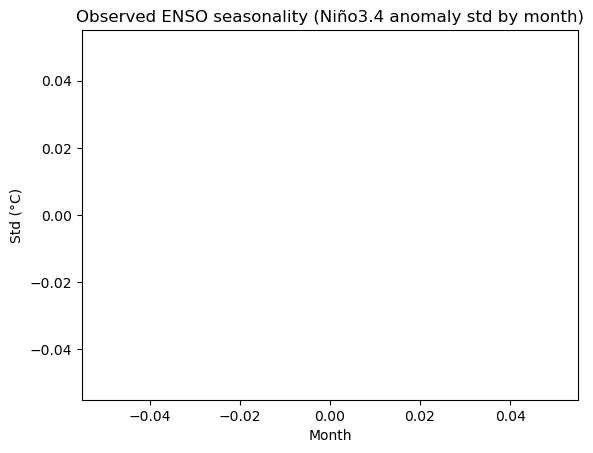

In [23]:
def monthly_std(idx):
    return idx.groupby("time.month").std("time")

std_obs = monthly_std(n34_obs_anom_dt)

plt.figure()
std_obs.plot(marker="o")
plt.title("Observed ENSO seasonality (Niño3.4 anomaly std by month)")
plt.xlabel("Month")
plt.ylabel("Std (°C)")
plt.show()


SST climatology of the ENSO-cycle” (ENSO composite by month)

In [ ]:
def enso_monthly_composite(idx, thresh_sigma=1.0):
    sigma = float(idx.std("time"))
    el = idx.where(idx >= thresh_sigma * sigma)
    la = idx.where(idx <= -thresh_sigma * sigma)
    return el.groupby("time.month").mean("time"), la.groupby("time.month").mean("time")

el_obs, la_obs = enso_monthly_composite(n34_obs)
el_m1,  la_m1  = enso_monthly_composite(n34_m1)
el_m2,  la_m2  = enso_monthly_composite(n34_m2)

plt.figure()
el_obs.plot(label="El Niño Obs")
el_m1.plot(label="El Niño gen1")
el_m2.plot(label="El Niño gen2")
plt.legend(); plt.title("El Niño composite Niño3.4 by month"); plt.show()

plt.figure()
la_obs.plot(label="La Niña Obs")
la_m1.plot(label="La Niña gen1")
la_m2.plot(label="La Niña gen2")
plt.legend(); plt.title("La Niña composite Niño3.4 by month"); plt.show()


Spatial ENSO patterns (pick the most relevant season, e.g., DJF)

In [ ]:
def seasonal_mean_per_year(da, season="DJF"):
    # seasonal mean for each year (xarray provides time.season)
    da_s = da.where(da["time.season"] == season)
    return da_s.groupby("time.year").mean("time")

def regression_map(sst_anom, idx, season="DJF"):
    sst_s = seasonal_mean_per_year(sst_anom, season=season)
    idx_s = seasonal_mean_per_year(idx,      season=season)

    sst_s, idx_s = xr.align(sst_s, idx_s, join="inner")

    idx_an = idx_s - idx_s.mean("year")
    sst_an = sst_s - sst_s.mean("year")

    slope = (sst_an * idx_an).mean("year") / (idx_an**2).mean("year")
    return slope

season = "DJF"

pat_obs = regression_map(obs_anom, n34_obs, season)
pat_m1  = regression_map(m1_anom,  n34_m1,  season)
pat_m2  = regression_map(m2_anom,  n34_m2,  season)

pat_obs.plot(); plt.title(f"Obs ENSO pattern (regression) {season}"); plt.show()
pat_m1.plot();  plt.title(f"Model gen1 ENSO pattern (regression) {season}"); plt.show()
pat_m2.plot();  plt.title(f"Model gen2 ENSO pattern (regression) {season}"); plt.show()


In [14]:
print(obs_sst)
print(m2_sst)


NameError: name 'obs_sst' is not defined

In [2]:
from pathlib import Path
import xarray as xr

DATA_DIR = Path("data/tos_Omon_MPI-ESM-P_past1000_r1i1p1_085001-184912")

OBS_PATH    = DATA_DIR / "HadISST_sst.nc"
MODEL1_PATH = DATA_DIR / "mil0010_EH5_mm_SST.nc"

print("OBS_PATH:", OBS_PATH.resolve())
print("MODEL1_PATH:", MODEL1_PATH.resolve())
print("OBS exists?", OBS_PATH.exists())
print("MODEL exists?", MODEL1_PATH.exists())

OBS_PATH: /workspaces/BERN03-Climate-system-modeling/Project 4 final/data/tos_Omon_MPI-ESM-P_past1000_r1i1p1_085001-184912/HadISST_sst.nc
MODEL1_PATH: /workspaces/BERN03-Climate-system-modeling/Project 4 final/data/tos_Omon_MPI-ESM-P_past1000_r1i1p1_085001-184912/mil0010_EH5_mm_SST.nc
OBS exists? True
MODEL exists? True


In [6]:
sst_obs, lat_o, lon_o = load_sst(OBS_PATH)
sst_m1,  lat_m, lon_m = load_sst(MODEL1_PATH)

print("Observed SST:")
print(sst_obs)

print("\nModel SST:")
print(sst_m1)

/tmp/ipykernel_10539/2315026716.py:7: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(path, decode_times=True, use_cftime=True)


: 

In [3]:
def standardize_lon(ds, lon_name="lon"):
    """Ensure lon is 0..360 and sorted."""
    lon = ds[lon_name]
    lon360 = (lon + 360) % 360
    ds = ds.assign_coords({lon_name: lon360}).sortby(lon_name)
    return ds

def guess_coord_names(ds):
    """Try to guess coordinate names commonly used in SST files."""
    # coordinates
    lat_name = "lat" if "lat" in ds.coords else ("latitude" if "latitude" in ds.coords else None)
    lon_name = "lon" if "lon" in ds.coords else ("longitude" if "longitude" in ds.coords else None)
    time_name = "time" if "time" in ds.coords else None
    if lat_name is None or lon_name is None or time_name is None:
        raise ValueError(f"Could not find expected coords. Found coords: {list(ds.coords)}")
    return lat_name, lon_name, time_name

def guess_sst_var(ds):
    """Guess SST variable name."""
    for v in ["tos", "sst", "SST", "sea_surface_temperature"]:
        if v in ds.data_vars:
            return v
    # fallback: first variable
    return list(ds.data_vars)[0]

def to_celsius(sst):
    """Convert to °C if it looks like Kelvin."""
    if float(sst.mean().values) > 100:  # heuristic
        return sst - 273.15
    return sst

def area_weights(lat):
    """Cos(lat) weights for area-weighted means."""
    return np.cos(np.deg2rad(lat))

def nino34_index(sst, lat_name="lat", lon_name="lon"):
    """
    Niño3.4 index: area-weighted mean SST over 5S–5N, 170W–120W.
    Using lon in 0..360: 190..240.
    """
    sst_box = sst.sel({lat_name: slice(-5, 5), lon_name: slice(190, 240)})
    w = area_weights(sst_box[lat_name])
    idx = sst_box.weighted(w).mean(dim=(lat_name, lon_name))
    idx.name = "nino3p4"
    return idx

def monthly_climatology(da):
    """Monthly climatology (12-month mean)."""
    return da.groupby("time.month").mean("time")

def monthly_anomalies(da):
    """Remove monthly climatology."""
    clim = monthly_climatology(da)
    anom = da.groupby("time.month") - clim
    return anom, clim

In [1]:
def load_sst(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Could not find file: {path}\nCWD: {Path.cwd()}")

    # Decode times but allow cftime when needed
    ds = xr.open_dataset(path, decode_times=True, use_cftime=True)

    lat_name, lon_name, time_name = guess_coord_names(ds)
    sst_var = guess_sst_var(ds)

    ds = standardize_lon(ds, lon_name=lon_name)
    sst = ds[sst_var]

    # ---- NEW: convert common fill values to NaN ----
    # Many SST datasets use -1000 or similar for missing
    sst = sst.where(sst > -100)  # keeps real SST, drops -1000 etc.

    # If SST has extra dims (e.g., depth), select surface/first
    for dim in ["lev", "depth", "z", "olevel"]:
        if dim in sst.dims:
            sst = sst.isel({dim: 0})

    sst = to_celsius(sst)

    return sst, lat_name, lon_name

In [2]:
n34_obs = nino34_index(sst_obs, lat_name=lat_o, lon_name=lon_o)
n34_m1  = nino34_index(sst_m1,  lat_name=lat_m, lon_name=lon_m)

n34_obs_anom, n34_obs_clim = monthly_anomalies(n34_obs)
n34_m1_anom,  n34_m1_clim  = monthly_anomalies(n34_m1)

NameError: name 'nino34_index' is not defined

In [29]:
sst_obs, lat_o, lon_o = load_sst(OBS_PATH)
sst_m1,  lat_m, lon_m = load_sst(MODEL1_PATH)

print("OBS min/max:", float(sst_obs.min()), float(sst_obs.max()))
print("MODEL min/max:", float(sst_m1.min()), float(sst_m1.max()))

/var/folders/wv/1ssjhqyj7kx3lmckpdzp12600000gn/T/ipykernel_3613/2315026716.py:7: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(path, decode_times=True, use_cftime=True)
/var/folders/wv/1ssjhqyj7kx3lmckpdzp12600000gn/T/ipykernel_3613/2315026716.py:7: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(path, decode_times=True, use_cftime=True)


OBS min/max: -1.7999999523162842 34.76295852661133
MODEL min/max: -80.51275634765625 45.221893310546875


In [35]:
from pathlib import Path
import xarray as xr
import numpy as np

def load_sst(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Could not find file: {path}")

    ds = xr.open_dataset(path, decode_times=True, use_cftime=True)

    lat_name, lon_name, time_name = guess_coord_names(ds)
    sst_var = guess_sst_var(ds)

    ds = standardize_lon(ds, lon_name=lon_name)
    sst = ds[sst_var]

    # Remove depth dimension if present
    for dim in ["lev", "depth", "z", "olevel"]:
        if dim in sst.dims:
            sst = sst.isel({dim: 0})

    # ---- Convert to Celsius FIRST (important for Kelvin files) ----
    sst = to_celsius(sst)

    # ---- THEN clean missing/unphysical values ----
    # Works for HadISST (-1000) AND model weird fills (like -80C)
    sst = sst.where((sst > -5) & (sst < 50))

    return sst, lat_name, lon_name

In [36]:
sst_obs, lat_o, lon_o = load_sst(OBS_PATH)
sst_m1,  lat_m, lon_m = load_sst(MODEL1_PATH)

print("OBS min/max:", float(sst_obs.min()), float(sst_obs.max()))
print("MODEL min/max:", float(sst_m1.min()), float(sst_m1.max()))

/var/folders/wv/1ssjhqyj7kx3lmckpdzp12600000gn/T/ipykernel_3613/2175609256.py:10: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(path, decode_times=True, use_cftime=True)
/var/folders/wv/1ssjhqyj7kx3lmckpdzp12600000gn/T/ipykernel_3613/2175609256.py:10: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(path, decode_times=True, use_cftime=True)


OBS min/max: -1.7999999523162842 34.76295852661133
MODEL min/max: -4.999969482421875 45.221893310546875


In [37]:
n34_obs = nino34_index(sst_obs, lat_name=lat_o, lon_name=lon_o)
n34_m1  = nino34_index(sst_m1,  lat_name=lat_m, lon_name=lon_m)

n34_obs_anom, n34_obs_clim = monthly_anomalies(n34_obs)
n34_m1_anom,  n34_m1_clim  = monthly_anomalies(n34_m1)

/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedo

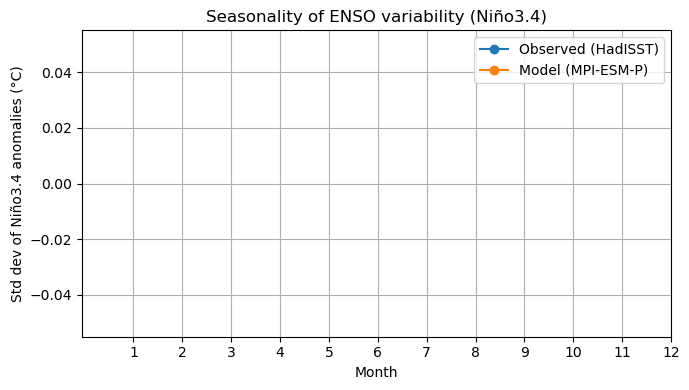

In [38]:
std_obs = n34_obs_anom.groupby("time.month").std("time")
std_m1  = n34_m1_anom.groupby("time.month").std("time")

plt.figure(figsize=(7,4))
plt.plot(std_obs.month, std_obs, marker="o", label="Observed (HadISST)")
plt.plot(std_m1.month,  std_m1,  marker="o", label="Model (MPI-ESM-P)")
plt.xticks(np.arange(1,13))
plt.xlabel("Month")
plt.ylabel("Std dev of Niño3.4 anomalies (°C)")
plt.title("Seasonality of ENSO variability (Niño3.4)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Replace unrealistic values with NaN (handles -80, -1000, etc.)
sst = sst.where((sst > -5) & (sst < 50))

NameError: name 'sst' is not defined

/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedo

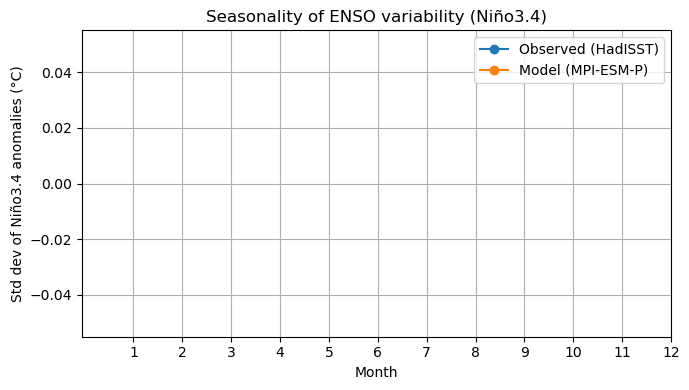

In [24]:
# Niño3.4 anomalies already computed:
# n34_obs_anom, n34_m1_anom

std_obs = n34_obs_anom.groupby("time.month").std("time")
std_m1  = n34_m1_anom.groupby("time.month").std("time")

plt.figure(figsize=(7,4))
plt.plot(std_obs.month, std_obs, marker="o", label="Observed (HadISST)")
plt.plot(std_m1.month,  std_m1,  marker="o", label="Model (MPI-ESM-P)")
plt.xticks(np.arange(1,13))
plt.xlabel("Month")
plt.ylabel("Std dev of Niño3.4 anomalies (°C)")
plt.title("Seasonality of ENSO variability (Niño3.4)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

“Seasonality in observed and simulated ENSO variability”

/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/bern03-climate/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedo

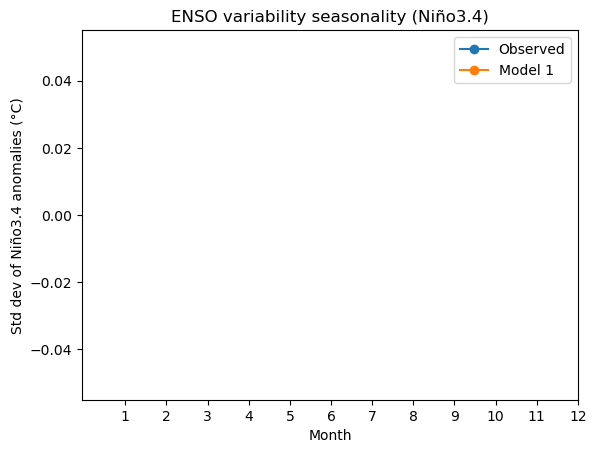

In [22]:
std_obs = n34_obs_anom.groupby("time.month").std("time")
std_m1  = n34_m1_anom.groupby("time.month").std("time")

plt.figure()
plt.plot(std_obs["month"], std_obs, marker="o", label="Observed")
plt.plot(std_m1["month"],  std_m1,  marker="o", label="Model 1")
plt.xticks(np.arange(1,13))
plt.xlabel("Month")
plt.ylabel("Std dev of Niño3.4 anomalies (°C)")
plt.title("ENSO variability seasonality (Niño3.4)")
plt.legend()
plt.show()

“SST climatology of the observed and simulated ENSO-cycle”

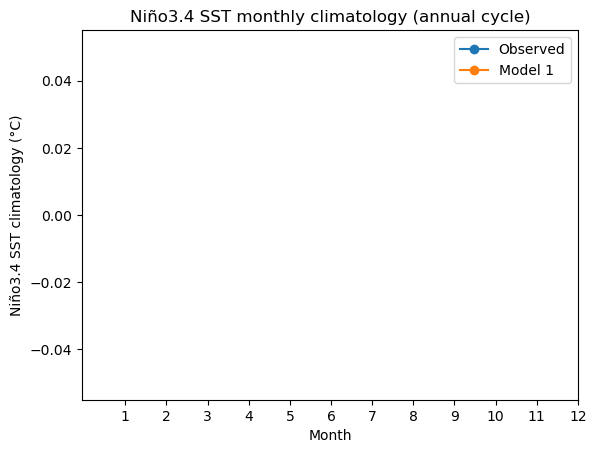

In [15]:
plt.figure()
plt.plot(n34_obs_clim["month"], n34_obs_clim, marker="o", label="Observed")
plt.plot(n34_m1_clim["month"],  n34_m1_clim,  marker="o", label="Model 1")
plt.xticks(np.arange(1,13))
plt.xlabel("Month")
plt.ylabel("Niño3.4 SST climatology (°C)")
plt.title("Niño3.4 SST monthly climatology (annual cycle)")
plt.legend()
plt.show()